In [2]:
import os
import sys

import numpy as np
import pandas as pd
import geopandas as gpd
import math
import shapely
import h3

import matplotlib.pyplot as plt
import plotly.express as px

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

2022-04-20 17:15:01 Configured OSMnx 1.1.1
2022-04-20 17:15:01 HTTP response caching is on


In [3]:
#Carga de archivo con códigos NAICS
naics_creative_lookup = pd.read_csv('/home/jovyan/work/data/external/naics_creative_short.csv')
naics_creative_lookup.head()

,code_en,sector_spanish,code_es,sector_english,creative_nesta_2016,creative_refined,creative_sector,has_creative,code_int
0,3279,Fabricación de otros productos a base de miner...,3279,Other nonmetallic mineral products manufacturingT,1.0,1.0,crafts,1,3279
1,32791,Fabricación de productos abrasivosT,32791,Abrasive products manufacturingT,1.0,1.0,crafts,1,32791
2,327910,Fabricación de productos abrasivos,327910,Abrasive products manufacturing,1.0,1.0,crafts,1,327910
3,32799,Fabricación de otros productos a base de miner...,32799,Other nonmetallic mineral products manufacturingT,1.0,1.0,crafts,1,32799
4,327991,Fabricación de productos a base de piedras de ...,327991,Manufacturing of products based on quarry stone,1.0,1.0,crafts,1,327991


In [4]:
# Get gdf to compare
#States
estados = gpd.read_file('/home/jovyan/work/data/external/mexico/mexico_estados.shp')
hex_mx = aup.gdf_from_db('hexgrid_5', 'hexgrid')

<AxesSubplot:>

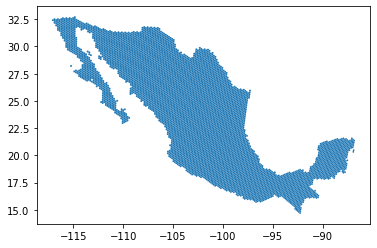

In [5]:
hex_mx.plot()

In [36]:
amenities1 = {'NAIC':[51]}

In [37]:
amenities1

{'NAIC': [51, 32]}

In [49]:
amenities = naics_creative_lookup['code_es']

In [50]:
denue_naics = gpd.GeoDataFrame()
for idx,cod in amenities.iteritems():
    query = f"SELECT * FROM denue.denue_2021 WHERE \"codigo_act\" LIKE \'{cod}%%\'"
    denue_naics = denue_naics.append(aup.gdf_from_query(query, geometry_col='geometry'))
denue_naics = denue_naics.to_crs("EPSG:4326")
denue_naics['codigo_act'] = denue_naics['codigo_act'].astype(int)

In [52]:
denue_naics['codigo_act'] = denue_naics['codigo_act'].astype(int)

In [7]:
for a in amenities:
    for cod in amenities[a]:
        query = f"SELECT * FROM denue.denue_2021 WHERE \"codigo_act\" LIKE \'{cod}%%\'"
        denue_51 = aup.gdf_from_query(query, geometry_col='geometry')

In [8]:
denue_51['codigo_act'] = denue_51['codigo_act'].astype(int)

In [53]:
denue_naics.shape

(300532, 43)

In [59]:
denue_naics.nombre_act.value_counts()[:10]

Servicios de fotografía y videograbación                                33573
Servicios de consultoría en administración                              18621
Otros servicios personales                                              15897
Escuelas de deporte del sector privado                                  15112
Fabricación de productos a base de piedras de cantera                   13260
Agencias de publicidad                                                  12912
Servicios veterinarios para mascotas prestados por el sector privado    12026
Diseño gráfico                                                          12015
Escuelas de arte del sector privado                                     11842
Servicios de diseño de sistemas de cómputo y servicios relacionados     10710
Name: nombre_act, dtype: int64

In [58]:
#Revisar lookup. Hacemos esto eliminando códigos duplicados en los datos. 
code_name_lu = denue_51[['codigo_act','nombre_act']].drop_duplicates('codigo_act').reset_index(drop=True)

 
#Hemos comparado los códigos en los datos con los códigos en el archivo NAICS y coinciden. 
#Vamos a trabjar con el archivo NAICS, complementado con los códigos del reporte de Nesta 2016.

In [12]:
denue_51_creative = pd.merge(denue_51,naics_creative_lookup,left_on='codigo_act',
                            right_on='code_int',how='left')

In [13]:
denue_51_creative.loc[denue_51_creative.creative_sector=='software',:].head()

,id,clee,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,...,geometry,code_en,sector_spanish,code_es,sector_english,creative_nesta_2016,creative_refined,creative_sector,has_creative,code_int
13,9330609,24028518210000081000028292S3,"CENTRO DE TRABAJO G.I.T. SAN LUIS POTOSI, S.L.P.",PETRÓLEOS MEXICANOS,518210,"Procesamiento electrónico de información, hosp...",0 a 5 personas,AVENIDA,Observatorio,CALLE,...,POINT (-100.95526 22.13706),518210.0,"Procesamiento electrónico de información, hosp...",518210.0,"Electronic data processing, hosting, and other...",1.0,1.0,software,1.0,518210.0
31,6509393,25001518210000013000028292S2,"T.I. EN TOPOLOBAMPO, SIN.",PETRÓLEOS MEXICANOS,518210,"Procesamiento electrónico de información, hosp...",11 a 30 personas,CALLE,Adolfo López Mateos,OTRO (ESPECIFIQUE),...,POINT (-109.04885 25.61751),518210.0,"Procesamiento electrónico de información, hosp...",518210.0,"Electronic data processing, hosting, and other...",1.0,1.0,software,1.0,518210.0
66,9338866,25006518210000121000000000U2,CONCLUTENCE SOLUCIONES,CONCLUTENCE SOLUCIONES SA DE CV,518210,"Procesamiento electrónico de información, hosp...",0 a 5 personas,BOULEVARD,NIÑOS HEROES,AVENIDA,...,POINT (-107.39976 24.81165),518210.0,"Procesamiento electrónico de información, hosp...",518210.0,"Electronic data processing, hosting, and other...",1.0,1.0,software,1.0,518210.0
76,3810389,25006518210000053000019702M7,POWER HOST,POWER CLOUD AND HOSTING SA DE CV,518210,"Procesamiento electrónico de información, hosp...",11 a 30 personas,CALLE,GENERAL IGNACIO RAMÍREZ,AVENIDA,...,POINT (-107.40541 24.79761),518210.0,"Procesamiento electrónico de información, hosp...",518210.0,"Electronic data processing, hosting, and other...",1.0,1.0,software,1.0,518210.0
91,6735544,25006518210000071000023979S9,SYSADVANCE,SYSADVANCE SA DE CV,518210,"Procesamiento electrónico de información, hosp...",0 a 5 personas,CALLE,LAGUNA DEL CARMEN,BOULEVARD,...,POINT (-107.37438 24.81147),518210.0,"Procesamiento electrónico de información, hosp...",518210.0,"Electronic data processing, hosting, and other...",1.0,1.0,software,1.0,518210.0


In [14]:
#Sectores creativos en los datos
denue_51_creative.creative_sector.value_counts()

libraries_museums        4786
film_radio_tv            3407
publishing               1557
software                  425
music_performing_arts     221
Name: creative_sector, dtype: int64

In [15]:
#Tamaño
pd.crosstab(denue_51_creative.per_ocu,denue_51_creative.creative_sector)

creative_sector,film_radio_tv,libraries_museums,music_performing_arts,publishing,software
per_ocu,,,,,
0 a 5 personas,1212,3999,181,814,142
101 a 250 personas,60,3,0,76,25
11 a 30 personas,870,282,14,237,102
251 y más personas,38,1,1,30,22
31 a 50 personas,356,31,4,82,32
51 a 100 personas,276,11,2,85,37
6 a 10 personas,595,459,19,233,65


In [16]:
#States
pd.crosstab(denue_51_creative.entidad,denue_51_creative.creative_sector)

creative_sector,film_radio_tv,libraries_museums,music_performing_arts,publishing,software
entidad,,,,,
Aguascalientes,27,35,2,22,9
Baja California,125,80,2,38,14
Baja California Sur,33,45,2,17,3
Campeche,42,38,1,18,5
Chiapas,148,174,8,38,4
Chihuahua,131,145,5,42,18
Ciudad de México,443,313,39,308,126
Coahuila de Zaragoza,129,136,3,45,5
Colima,35,43,2,14,3


In [17]:
#Municipios
pd.crosstab(denue_51_creative.municipio,denue_51_creative.creative_sector)[:20]

creative_sector,film_radio_tv,libraries_museums,music_performing_arts,publishing,software
municipio,,,,,
Abalá,0,1,0,0,0
Abasolo,0,6,0,0,0
Abejones,0,1,0,0,0
Acacoyagua,0,1,0,0,0
Acajete,0,7,0,0,0
Acala,0,0,0,1,0
Acambay de Ruíz Castañeda,0,2,0,0,0
Acanceh,0,1,0,0,0
Acapetahua,0,2,0,0,0


In [19]:
estados.head()

,CODIGO,ESTADO,geometry
0,MX02,Baja California,"MULTIPOLYGON (((-113.13972 29.01778, -113.2405..."
1,MX03,Baja California Sur,"MULTIPOLYGON (((-111.20612 25.80278, -111.2302..."
2,MX18,Nayarit,"MULTIPOLYGON (((-106.62108 21.56531, -106.6475..."
3,MX14,Jalisco,"POLYGON ((-101.52490 21.85664, -101.58830 21.7..."
4,MX01,Aguascalientes,"POLYGON ((-101.84620 22.01176, -101.96530 21.8..."


In [25]:
dfsjoin = gpd.sjoin(estados, denue_51) #Spatial join Points to polygons
dfpivot = pd.pivot_table(dfsjoin,index='ESTADO',columns='nombre_act',aggfunc={'nombre_act':len})
dfpivot.columns = dfpivot.columns.droplevel()

dfpolynew = estados.merge(dfpivot, how='left', on='ESTADO')

<AxesSubplot:>

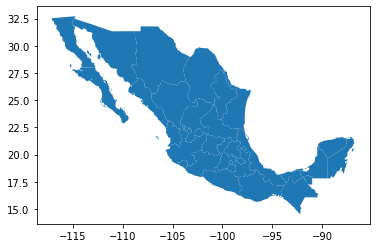

In [27]:
dfpolynew =  dfpolynew.fillna(0)
dfpolynew.plot()


In [29]:
dfpolynew.head()

,CODIGO,ESTADO,geometry,Agencias noticiosas,Bibliotecas y archivos del sector privado,Bibliotecas y archivos del sector público,Distribución de películas y de otros materiales audiovisuales,Edición de directorios y de listas de correo,Edición de directorios y de listas de correo integrada con la impresión,Edición de libros,...,Otros servicios de telecomunicaciones,"Procesamiento electrónico de información, hospedaje y otros servicios relacionados",Producción de películas,Producción de programación de canales para sistemas de televisión por cable o satelitales,Producción de programas para la televisión,"Producción de videoclips, comerciales y otros materiales audiovisuales",Productoras y distribuidoras discográficas,Servicios de postproducción y otros servicios para la industria fílmica y del video,Transmisión de programas de radio,Transmisión de programas de televisión
0,MX02,Baja California,"MULTIPOLYGON (((-113.13972 29.01778, -113.2405...",5.0,9.0,68.0,0.0,1.0,0.0,3.0,...,65.0,11.0,0.0,1.0,5.0,5.0,0.0,0.0,59.0,19.0
1,MX03,Baja California Sur,"MULTIPOLYGON (((-111.20612 25.80278, -111.2302...",1.0,3.0,36.0,0.0,1.0,0.0,0.0,...,17.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,10.0
2,MX18,Nayarit,"MULTIPOLYGON (((-106.62108 21.56531, -106.6475...",1.0,3.0,61.0,0.0,0.0,0.0,1.0,...,41.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,11.0,6.0
3,MX14,Jalisco,"POLYGON ((-101.52490 21.85664, -101.58830 21.7...",2.0,26.0,228.0,1.0,1.0,0.0,10.0,...,260.0,18.0,3.0,2.0,10.0,11.0,2.0,2.0,69.0,12.0
4,MX01,Aguascalientes,"POLYGON ((-101.84620 22.01176, -101.96530 21.8...",1.0,1.0,33.0,0.0,0.0,0.0,1.0,...,40.0,7.0,0.0,0.0,1.0,2.0,0.0,0.0,8.0,6.0


In [28]:
dfpolynew.to_file('NAIC_edo.geojson')